In [1]:
import os
import shutil
import json
import tempfile
import pickle
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from run_experiments import run_experiments, Result

In [2]:
# set envvars
# os.environ["OS_MEMORY_ALLOC_OVERRIDE"] = "25000000"
# os.environ["ENGINE_PATH"] = "./target/x86_64-apple-darwin/release/hash_engine"
os.environ["RUST_LOG"] = "info"
os.environ["ENGINE_WAIT_TIMEOUT"] = "300"
os.environ["ENGINE_TARGET_MAX_GROUP_SIZE"] = "10000000"

In [3]:
# we need cwd to be the engine folder
os.chdir("./..")

In [4]:
# clear the output folders
def clear_outputs():
    try:
        shutil.rmtree('./output')
        shutil.rmtree('./parts')
    except FileNotFoundError:
        pass

In [5]:
def write_to_globals_and_benchmark(src_path: Path, globals_override: dict, num_steps: int):
    clear_outputs()
    with tempfile.TemporaryDirectory() as temp_folder:
        temp_path = shutil.copytree(
            src_path, 
            Path(temp_folder) / src_path.name # Python < 3.8 requires the directory to not already exist for copytree
        )
        
        # override the globals
        globals_path = temp_path / "src" / "globals.json"
        global_properties = json.loads(globals_path.read_text())
        global_properties.update(globals_override)
        globals_path.write_text(json.dumps(global_properties))
        
        # benchmark a single-run
        results = run_experiments(
            project_paths=[temp_path], 
            run_all_experiments=False,
            cli_args=["single-run", "--num-steps", f"{num_steps}"],
            texray=True
        )
        
        return results

In [6]:
def plot_time_and_mem(results):
    agents_to_uss = [(num_agents, res.max_uss_memory) for (num_agents, res) in results]
    agents_to_pss = [(num_agents, res.max_pss_memory) for (num_agents, res) in results]
    agents_to_time = [(num_agents, res.time_to_completion) for (num_agents, res) in results]
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('Time Taken by Number of Agents')
    ax.set_xlabel('Number of Agents')
    # ax.set_xscale('log')
    ax.set_ylabel('Time Taken (s)')
    ax.plot(*zip(*agents_to_time))
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('Max PSS by Number of Agents')
    ax.set_xlabel('Number of Agents')
    # ax.set_xscale('log')
    ax.set_ylabel('Max PSS (Proportional Set Size) memory')
    ax.plot(*zip(*agents_to_pss))
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('Max USS by Number of Agents')
    ax.set_xlabel('Number of Agents')
    # ax.set_xscale('log')
    ax.set_ylabel('Max USS (Unique Set Size) memory')
    ax.plot(*zip(*agents_to_uss))

In [7]:
# src_path = Path("./benchmarking/experiments/num_agents/no_behaviors/init_js/2_fields")
# write_to_globals_and_benchmark(src_path, {"num_agents": 5}, num_steps=2)

### Benchmark Number of Agents without Behaviors

Benchmarking with 50 agents


    Finished release [optimized] target(s) in 0.47s


Running Experiment with cmd: cargo run --release --bin cli --features texray -- -p /tmp/tmp0m3yu28l/long-age single-run --num-steps 50
Time taken: 2.466059684753418
max_vms_memory: 9701126144
max_rss_memory: 90910720
max_pss_memory: 79319040
Running Experiment finished


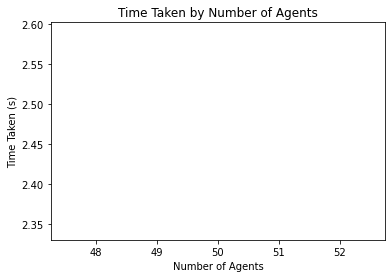

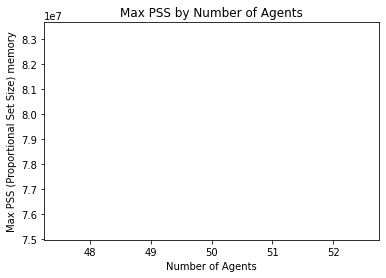

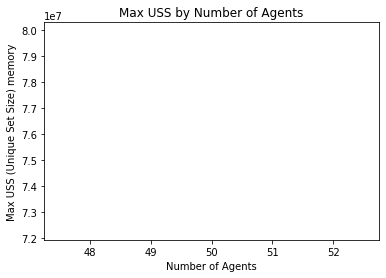

In [8]:
src_path = Path("./benchmarking/experiments/stress_test/long-age")

results = []
total_results_to_pickle = []
# for num_agents in [10_000, 25_000, 50_000, 75_000, 100_000, 125_000, 250_000, 375_000, 500_000]:
for num_agents in [50]:
    print(f"Benchmarking with {num_agents} agents")
    res = write_to_globals_and_benchmark(src_path, {"num_agents": num_agents}, num_steps=50)
    total_results_to_pickle.append(res)
    try:
        res = list(list(res.values())[0].values())[0] # TODO rework API to make this less unpleasant
        results.append((num_agents, res))
    except (AttributeError, IndexError): # if an experiment fails it's a NoneType, maybe we don't want to swallow errors
        pass
    
plot_time_and_mem(results)

In [9]:
for (num_agents, res) in results:
    print(res.texray_output)

defaultdict(<class 'float'>, {'sim': 1.7770000000000001, 'init_packages': 0.05, 'context_packages': 0.2780000000000002, 'snapshot_sync': 0.12116100000000002, 'state_sync': 0.12981900000000007, 'run_context_packages': 0.04780899999999999, 'context_sync': 0.05805099999999999, 'state_packages': 0.40400000000000025, 'output_packages': 0.04363399999999999})


In [10]:
pickle_path = Path("pickles.txt")

In [12]:
pickle_path.write_bytes(pickle.dumps(total_results_to_pickle))

798